<a href="https://colab.research.google.com/github/FranBasili/JPEG-Encoder/blob/main/Compresion_JPEG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Compresor JPEG

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
import os

!pip install bitstring
from bitstring import BitArray

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.3/288.3 kB 16.2 MB/s eta 0:00:00


# Transformación de espacio color


In [2]:
RGB2YCbCr_MATRIX = np.array([[0.299, 0.587, 0.114],
                             [-0.168, -0.332, 0.5],
                             [0.5, -0.419, -0.081]])

YCbCr2RGB_MATRIX = np.array([[1, 0, 1.402],
                             [1, -0.344, -0.714],
                             [1, 1.772, 0]])

def RGB2YCbCr(img):
  out = img.dot(RGB2YCbCr_MATRIX.T)
  out[:,:,[1,2]] += 128
  return np.uint8(out)

def YCbCr2RGB(img):
  img[:,:,[1,2]] -= 128
  aux = img.dot(YCbCr2RGB_MATRIX.T)
  return np.uint8(np.clip(aux, 0, 255))

# Downsampling / Upsampling

In [3]:
# el subsampling se podria hacer promediando
def chroma_subsampling(img, size='4:2:0'):
  if size == '4:4:4':
    return img

  elif size == "4:2:2":
    return [img[:,:,0], img[:,::2,1], img[:,::2,2]]

  elif size == '4:2:0':
    return np.array([img[:,:,0], img[::2,::2,1], img[::2,::2,2]], dtype=object)

def chroma_upsampling(img):
  return np.array([img[0],
                  cv2.resize(img[1], img[0].shape, interpolation=cv2.INTER_LINEAR),
                  cv2.resize(img[2], img[0].shape, interpolation=cv2.INTER_LINEAR)])

#DCT & IDCT

## Formato manual

Formula para Transformada discreta coseno:

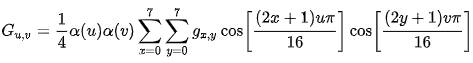

Formula para Transformada Inversa discreta coseno:

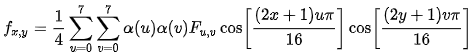

In [4]:
alfa = lambda x: 1/np.sqrt(2) if x==0 else 1
func = lambda x,u: np.cos((2*x+1)*u*np.pi/16)

def DCT(matrix): # Testeado
  matrix = matrix - 128 # Centramos en 0
  out = np.zeros_like(matrix)
  size = matrix.shape[0]

  for u in range(size):
    for v in range(size):
      aux = 0

      for x in range(size):
        for y in range(size):
          aux += matrix[x,y] * func(x,u) * func(y,v)

      out[u,v] = 0.25 * alfa(u) * alfa(v) * aux

  return out


def IDCT(matrix):
  out = np.zeros_like(matrix)
  size = matrix.shape[0]

  for x in range(size):
    for y in range(size):
      aux = 0

      for u in range(size):
        for v in range(size):
          aux += alfa(u) * alfa(v) * matrix[u,v] * func(x,u) * func(y,v)

      out[x,y] = 0.25 * aux

  return (out+128)

## Formato scipy

In [5]:
def applyDCT(mat):
  aux = np.subtract(mat, 128, dtype=np.int8)
  return sc.fft.dctn(aux, type=2, norm='ortho')

applyIDCT = lambda mat: sc.fft.idctn(mat, type=2, norm='ortho')+128

# Quantization

$Q_x = \frac{50}{x} \times Q_{50}$ (http://acta.uni-obuda.hu/Poth_Trpovski_Loncar-Turukalo_103.pdf)

In [6]:
Q50_LUM = np.array([[16, 11, 10, 16,  24,  40,  51,  61],
                    [12, 12, 14, 19,  26,  58,  60,  55],
                    [14, 13, 16, 24,  40,  57,  69,  56],
                    [14, 17, 22, 29,  51,  87,  80,  62],
                    [18, 22, 37, 56,  68, 109, 103,  77],
                    [24, 35, 55, 64,  81, 104, 113,  92],
                    [49, 64, 78, 87, 103, 121, 120, 101],
                    [72, 92, 95, 98, 112, 100, 103,  99]])

Q50_CHR = np.array([[17, 18, 24, 47, 99, 99, 99, 99],
                    [18, 21, 26, 66, 99, 99, 99, 99],
                    [24, 26, 56, 99, 99, 99, 99, 99],
                    [47, 66, 99, 99, 99, 99, 99, 99],
                    [99, 99, 99, 99, 99, 99, 99, 99],
                    [99, 99, 99, 99, 99, 99, 99, 99],
                    [99, 99, 99, 99, 99, 99, 99, 99],
                    [99, 99, 99, 99, 99, 99, 99, 99] ])

def getQMat(QF=50, plane="LUM"):
  if QF == 100:
    return np.ones((8,8))

  Q50 = Q50_LUM if plane == "LUM" else Q50_CHR
  QMat= (100-QF)*Q50/50 if QF>=50 else Q50*(50/QF)
  return QMat

def quantize(matrix, QF=50, plane="LUM"):
  return np.round(matrix / getQMat(QF=QF, plane=plane))

def dequantize(matrix, QF=50, plane="LUM"):
  return (matrix*getQMat(QF=QF, plane=plane))

# DCT+Quant Wrapper

In [7]:
BLOCK_SIZE = 8

def DCT_Quant_plane(img, QF=50, plane="LUM"):  # Testeado y comentar
  out = np.zeros_like(img, dtype=np.float64)

  for i in range(0, img.shape[0], BLOCK_SIZE):
    for j in range(0, img.shape[1], BLOCK_SIZE):
      DCT = applyDCT(img[i:i+BLOCK_SIZE,j:j+BLOCK_SIZE])
      out[i:i+BLOCK_SIZE,j:j+BLOCK_SIZE] = quantize(DCT, QF=QF, plane=plane)

  return out

def IDCT_Quant_plane(img, QF=50, plane="LUM"):  # Testeado y comentar
  out = np.zeros_like(img)

  for i in range(img.shape[0]//8):
    for j in range(img.shape[1]//8):
      dequantized = dequantize(img[i:i+8,j:j+8], QF=QF, plane=plane)
      out[i:i+8,j:j+8] = applyIDCT(dequantized)

  return out

def DCT_Quant(img, QF=50):
  aux = np.zeros_like(img)

  aux[0] = DCT_Quant_plane(img[0], QF, plane="LUM")
  aux[1] = DCT_Quant_plane(img[1], QF, plane="CHR")
  aux[2] = DCT_Quant_plane(img[2], QF, plane="CHR")
  return aux

def IDCT_Quant(img, QF=50):
  aux = np.zeros_like(img)

  aux[0] = IDCT_Quant_plane(img[0], QF, plane="LUM")
  aux[1] = IDCT_Quant_plane(img[1], QF, plane="CHR")
  aux[2] = IDCT_Quant_plane(img[2], QF, plane="CHR")
  return aux

# Encoding/Decoding

## Ordenamiento ZigZag

In [8]:
ZIGZAG_ORDER = [ 0,  1,  8, 16,  9,  2,  3, 10,
                17, 24, 32, 25, 18, 11,  4,  5,
                12, 19, 26, 33, 40, 48, 41, 34,
                27, 20, 13,  6,  7, 14, 21, 28,
                35, 42, 49, 56, 57, 50, 43, 36,
                29, 22, 15, 23, 30, 37, 44, 51,
                58, 59, 52, 45, 38, 31, 39, 46,
                53, 60, 61, 54, 47, 55, 62, 63]

UNZIGZAG_ORDER = [ 0,  1,  5,  6, 14, 15, 27, 28,
                   2,  4,  7, 13, 16, 26, 29, 42,
                   3,  8, 12, 17, 25, 30, 41, 43,
                   9, 11, 18, 24, 31, 40, 44, 53,
                  10, 19, 23, 32, 39, 45, 52, 54,
                  20, 22, 33, 38, 46, 51, 55, 60,
                  21, 34, 37, 47, 50, 56, 59, 61,
                  35, 36, 48, 49, 57, 58, 62, 63]

matrix2zigzag = lambda mat: np.array([mat[i//8, i%8] for i in ZIGZAG_ORDER])
zigzag2matrix = lambda arr: np.array([arr[i] for i in UNZIGZAG_ORDER]).reshape(8,8)

## RLE

In [9]:
# Pasa de arreglo a [(cant_zeros_prev, val), (cant_zeros_prev, val), ...]
def RLE_encoding(array):
    encoded = []
    encoded.append((0, array[0]))

    count = 0
    for char in array[1:]:
        if char == 0:
          count += 1

          if count == 16:   # Arreglo de 16 0's
            encoded.append((15, 0))
            count = 0

        else:   # Numero precedido por count 0's
          encoded.append((count, char))
          count = 0

    # Si el archivo termina con un arreglo de menos de 16 ceros
    if count != 0:
      encoded.append((0, 0))

    return encoded

def RLE_decoding(array):
    decoded=[]
    _, dc_val = array.pop(0)
    decoded.append(dc_val)

    for count, char in array: # Para cada par
      for i in range(count):  # Appendeamos cant 0's
        decoded.append(0)

      if char != 0:
        decoded.append(char)  # y el value

    # completamos el bloque con 0's
    for i in range(64-len(decoded)):
      decoded.append(0)

    return decoded

##Codificación Huffman

### Tablas Huffman

Tablas extraidas de [Standard Codecs: Image Compression to Advanced Video Coding (IET Telecommunications Series)](https://flylib.com/books/en/2.537.1.107/1/)

Obs: se encontró la tabla para valores de luminicencia, se consideró que los de cromacidad eran equivalentes.

In [10]:
Y_DC_ENCODE = {
    0: "00",
    1: "010",
    2: "011",
    3: "100",
    4: "101",
    5: "110",
    6: "1110",
    7: "11110",
    8: "111110",
    9: "1111110",
    10: "11111110",
    11: "111111110",
}
Y_DC_DECODE = {
    "00": 0,
    "010": 1,
    "011": 2,
    "100": 3,
    "101": 4,
    "110": 5,
    "1110": 6,
    "11110": 7,
    "111110": 8,
    "1111110": 9,
    "11111110": 10,
    "111111110": 11,
}
Y_AC_ENCODE = {
    (0, 0): "1010",
    (0, 1): "00",
    (0, 2): "01",
    (0, 3): "100",
    (0, 4): "1011",
    (0, 5): "11010",
    (0, 6): "1111000",
    (0, 7): "11111000",
    (0, 8): "1111110110",
    (0, 9): "1111111110000010",
    (0, 10): "1111111110000011",
    (1, 1): "1100",
    (1, 2): "11011",
    (1, 3): "1111001",
    (1, 4): "111110110",
    (1, 5): "11111110110",
    (1, 6): "1111111110000100",
    (1, 7): "1111111110000101",
    (1, 8): "1111111110000110",
    (1, 9): "1111111110000111",
    (1, 10): "1111111110001000",
    (2, 1): "11100",
    (2, 2): "11111001",
    (2, 3): "1111110111",
    (2, 4): "111111110100",
    (2, 5): "1111111110001001",
    (2, 6): "1111111110001010",
    (2, 7): "1111111110001011",
    (2, 8): "1111111110001100",
    (2, 9): "1111111110001101",
    (2, 10): "1111111110001110",
    (3, 1): "111010",
    (3, 2): "111110111",
    (3, 3): "111111110101",
    (3, 4): "1111111110001111",
    (3, 5): "1111111110010000",
    (3, 6): "1111111110010001",
    (3, 7): "1111111110010010",
    (3, 8): "1111111110010011",
    (3, 9): "1111111110010100",
    (3, 10): "1111111110010101",
    (4, 1): "111011",
    (4, 2): "1111111000",
    (4, 3): "1111111110010110",
    (4, 4): "1111111110010111",
    (4, 5): "1111111110011000",
    (4, 6): "1111111110011001",
    (4, 7): "1111111110011010",
    (4, 8): "1111111110011011",
    (4, 9): "1111111110011100",
    (4, 10): "1111111110011101",
    (5, 1): "1111010",
    (5, 2): "11111110111",
    (5, 3): "1111111110011110",
    (5, 4): "1111111110011111",
    (5, 5): "1111111110100000",
    (5, 6): "1111111110100001",
    (5, 7): "1111111110100010",
    (5, 8): "1111111110100011",
    (5, 9): "1111111110100100",
    (5, 10): "1111111110100101",
    (6, 1): "1111011",
    (6, 2): "111111110110",
    (6, 3): "1111111110100110",
    (6, 4): "1111111110100111",
    (6, 5): "1111111110101000",
    (6, 6): "1111111110101001",
    (6, 7): "1111111110101010",
    (6, 8): "1111111110101011",
    (6, 9): "1111111110101100",
    (6, 10): "1111111110101101",
    (7, 1): "11111010",
    (7, 2): "111111110111",
    (7, 3): "1111111110101110",
    (7, 4): "1111111110101111",
    (7, 5): "1111111110110000",
    (7, 6): "1111111110110001",
    (7, 7): "1111111110110010",
    (7, 8): "1111111110110011",
    (7, 9): "1111111110110100",
    (7, 10): "1111111110110101",
    (8, 1): "111111000",
    (8, 2): "111111111000000",
    (8, 3): "1111111110110110",
    (8, 4): "1111111110110111",
    (8, 5): "1111111110111000",
    (8, 6): "1111111110111001",
    (8, 7): "1111111110111010",
    (8, 8): "1111111110111011",
    (8, 9): "1111111110111100",
    (8, 10): "1111111110111101",
    (9, 1): "111111001",
    (9, 2): "1111111110111110",
    (9, 3): "1111111110111111",
    (9, 4): "1111111111000000",
    (9, 5): "1111111111000001",
    (9, 6): "1111111111000010",
    (9, 7): "1111111111000011",
    (9, 8): "1111111111000100",
    (9, 9): "1111111111000101",
    (9, 10): "1111111111000110",
    (10, 1): "111111010",
    (10, 2): "1111111111000111",
    (10, 3): "1111111111001000",
    (10, 4): "1111111111001001",
    (10, 5): "1111111111001010",
    (10, 6): "1111111111001011",
    (10, 7): "1111111111001100",
    (10, 8): "1111111111001101",
    (10, 9): "1111111111001110",
    (10, 10): "1111111111001111",
    (11, 1): "1111111001",
    (11, 2): "1111111111010000",
    (11, 3): "1111111111010001",
    (11, 4): "1111111111010010",
    (11, 5): "1111111111010011",
    (11, 6): "1111111111010100",
    (11, 7): "1111111111010101",
    (11, 8): "1111111111010110",
    (11, 9): "1111111111010111",
    (11, 10): "1111111111011000",
    (12, 1): "1111111010",
    (12, 2): "1111111111011001",
    (12, 3): "1111111111011010",
    (12, 4): "1111111111011011",
    (12, 5): "1111111111011100",
    (12, 6): "1111111111011101",
    (12, 7): "1111111111011110",
    (12, 8): "1111111111011111",
    (12, 9): "1111111111100000",
    (12, 10): "1111111111100001",
    (13, 1): "11111111000",
    (13, 2): "1111111111100010",
    (13, 3): "1111111111100011",
    (13, 4): "1111111111100100",
    (13, 5): "1111111111100101",
    (13, 6): "1111111111100110",
    (13, 7): "1111111111100111",
    (13, 8): "1111111111101000",
    (13, 9): "1111111111101001",
    (13, 10): "1111111111101010",
    (14, 1): "1111111111101011",
    (14, 2): "1111111111101100",
    (14, 3): "1111111111101101",
    (14, 4): "1111111111101110",
    (14, 5): "1111111111101111",
    (14, 6): "1111111111110000",
    (14, 7): "1111111111110001",
    (14, 8): "1111111111110010",
    (14, 9): "1111111111110011",
    (14, 10): "1111111111110100",
    (15, 1): "1111111111110101",
    (15, 2): "1111111111110110",
    (15, 3): "1111111111110111",
    (15, 4): "1111111111111000",
    (15, 5): "1111111111111001",
    (15, 6): "1111111111111010",
    (15, 7): "1111111111111011",
    (15, 8): "1111111111111100",
    (15, 9): "1111111111111101",
    (15, 10): "1111111111111110",
    (15, 0): "11111111001",
}
Y_AC_DECODE = {
    "1010": (0, 0),
    "00": (0, 1),
    "01": (0, 2),
    "100": (0, 3),
    "1011": (0, 4),
    "11010": (0, 5),
    "1111000": (0, 6),
    "11111000": (0, 7),
    "1111110110": (0, 8),
    "1111111110000010": (0, 9),
    "1111111110000011": (0, 10),
    "1100": (1, 1),
    "11011": (1, 2),
    "1111001": (1, 3),
    "111110110": (1, 4),
    "11111110110": (1, 5),
    "1111111110000100": (1, 6),
    "1111111110000101": (1, 7),
    "1111111110000110": (1, 8),
    "1111111110000111": (1, 9),
    "1111111110001000": (1, 10),
    "11100": (2, 1),
    "11111001": (2, 2),
    "1111110111": (2, 3),
    "111111110100": (2, 4),
    "1111111110001001": (2, 5),
    "1111111110001010": (2, 6),
    "1111111110001011": (2, 7),
    "1111111110001100": (2, 8),
    "1111111110001101": (2, 9),
    "1111111110001110": (2, 10),
    "111010": (3, 1),
    "111110111": (3, 2),
    "111111110101": (3, 3),
    "1111111110001111": (3, 4),
    "1111111110010000": (3, 5),
    "1111111110010001": (3, 6),
    "1111111110010010": (3, 7),
    "1111111110010011": (3, 8),
    "1111111110010100": (3, 9),
    "1111111110010101": (3, 10),
    "111011": (4, 1),
    "1111111000": (4, 2),
    "1111111110010110": (4, 3),
    "1111111110010111": (4, 4),
    "1111111110011000": (4, 5),
    "1111111110011001": (4, 6),
    "1111111110011010": (4, 7),
    "1111111110011011": (4, 8),
    "1111111110011100": (4, 9),
    "1111111110011101": (4, 10),
    "1111010": (5, 1),
    "11111110111": (5, 2),
    "1111111110011110": (5, 3),
    "1111111110011111": (5, 4),
    "1111111110100000": (5, 5),
    "1111111110100001": (5, 6),
    "1111111110100010": (5, 7),
    "1111111110100011": (5, 8),
    "1111111110100100": (5, 9),
    "1111111110100101": (5, 10),
    "1111011": (6, 1),
    "111111110110": (6, 2),
    "1111111110100110": (6, 3),
    "1111111110100111": (6, 4),
    "1111111110101000": (6, 5),
    "1111111110101001": (6, 6),
    "1111111110101010": (6, 7),
    "1111111110101011": (6, 8),
    "1111111110101100": (6, 9),
    "1111111110101101": (6, 10),
    "11111010": (7, 1),
    "111111110111": (7, 2),
    "1111111110101110": (7, 3),
    "1111111110101111": (7, 4),
    "1111111110110000": (7, 5),
    "1111111110110001": (7, 6),
    "1111111110110010": (7, 7),
    "1111111110110011": (7, 8),
    "1111111110110100": (7, 9),
    "1111111110110101": (7, 10),
    "111111000": (8, 1),
    "111111111000000": (8, 2),
    "1111111110110110": (8, 3),
    "1111111110110111": (8, 4),
    "1111111110111000": (8, 5),
    "1111111110111001": (8, 6),
    "1111111110111010": (8, 7),
    "1111111110111011": (8, 8),
    "1111111110111100": (8, 9),
    "1111111110111101": (8, 10),
    "111111001": (9, 1),
    "1111111110111110": (9, 2),
    "1111111110111111": (9, 3),
    "1111111111000000": (9, 4),
    "1111111111000001": (9, 5),
    "1111111111000010": (9, 6),
    "1111111111000011": (9, 7),
    "1111111111000100": (9, 8),
    "1111111111000101": (9, 9),
    "1111111111000110": (9, 10),
    "111111010": (10, 1),
    "1111111111000111": (10, 2),
    "1111111111001000": (10, 3),
    "1111111111001001": (10, 4),
    "1111111111001010": (10, 5),
    "1111111111001011": (10, 6),
    "1111111111001100": (10, 7),
    "1111111111001101": (10, 8),
    "1111111111001110": (10, 9),
    "1111111111001111": (10, 10),
    "1111111001": (11, 1),
    "1111111111010000": (11, 2),
    "1111111111010001": (11, 3),
    "1111111111010010": (11, 4),
    "1111111111010011": (11, 5),
    "1111111111010100": (11, 6),
    "1111111111010101": (11, 7),
    "1111111111010110": (11, 8),
    "1111111111010111": (11, 9),
    "1111111111011000": (11, 10),
    "1111111010": (12, 1),
    "1111111111011001": (12, 2),
    "1111111111011010": (12, 3),
    "1111111111011011": (12, 4),
    "1111111111011100": (12, 5),
    "1111111111011101": (12, 6),
    "1111111111011110": (12, 7),
    "1111111111011111": (12, 8),
    "1111111111100000": (12, 9),
    "1111111111100001": (12, 10),
    "11111111000": (13, 1),
    "1111111111100010": (13, 2),
    "1111111111100011": (13, 3),
    "1111111111100100": (13, 4),
    "1111111111100101": (13, 5),
    "1111111111100110": (13, 6),
    "1111111111100111": (13, 7),
    "1111111111101000": (13, 8),
    "1111111111101001": (13, 9),
    "1111111111101010": (13, 10),
    "1111111111101011": (14, 1),
    "1111111111101100": (14, 2),
    "1111111111101101": (14, 3),
    "1111111111101110": (14, 4),
    "1111111111101111": (14, 5),
    "1111111111110000": (14, 6),
    "1111111111110001": (14, 7),
    "1111111111110010": (14, 8),
    "1111111111110011": (14, 9),
    "1111111111110100": (14, 10),
    "1111111111110101": (15, 1),
    "1111111111110110": (15, 2),
    "1111111111110111": (15, 3),
    "1111111111111000": (15, 4),
    "1111111111111001": (15, 5),
    "1111111111111010": (15, 6),
    "1111111111111011": (15, 7),
    "1111111111111100": (15, 8),
    "1111111111111101": (15, 9),
    "1111111111111110": (15, 10),
    "11111111001": (15, 0),
}


CH_DC_ENCODE = {
    0: "00",
    1: "01",
    2: "10",
    3: "110",
    4: "1110",
    5: "11110",
    6: "111110",
    7: "1111110",
    8: "11111110",
    9: "111111110",
    10:"1111111110",
    11:"11111111110",
}
CH_DC_DECODE = {
    "00": 0,
    "01": 1,
    "10": 2,
    "110": 3,
    "1110": 4,
    "11110": 5,
    "111110": 6,
    "1111110": 7,
    "11111110": 8,
    "111111110": 9,
    "1111111110": 10,
    "11111111110": 11,
}
CH_AC_ENCODE = {
    (0, 0): "1010",
    (0, 1): "00",
    (0, 2): "01",
    (0, 3): "100",
    (0, 4): "1011",
    (0, 5): "11010",
    (0, 6): "1111000",
    (0, 7): "11111000",
    (0, 8): "1111110110",
    (0, 9): "1111111110000010",
    (0, 10): "1111111110000011",
    (1, 1): "1100",
    (1, 2): "11011",
    (1, 3): "1111001",
    (1, 4): "111110110",
    (1, 5): "11111110110",
    (1, 6): "1111111110000100",
    (1, 7): "1111111110000101",
    (1, 8): "1111111110000110",
    (1, 9): "1111111110000111",
    (1, 10): "1111111110001000",
    (2, 1): "11100",
    (2, 2): "11111001",
    (2, 3): "1111110111",
    (2, 4): "111111110100",
    (2, 5): "1111111110001001",
    (2, 6): "1111111110001010",
    (2, 7): "1111111110001011",
    (2, 8): "1111111110001100",
    (2, 9): "1111111110001101",
    (2, 10): "1111111110001110",
    (3, 1): "111010",
    (3, 2): "111110111",
    (3, 3): "111111110101",
    (3, 4): "1111111110001111",
    (3, 5): "1111111110010000",
    (3, 6): "1111111110010001",
    (3, 7): "1111111110010010",
    (3, 8): "1111111110010011",
    (3, 9): "1111111110010100",
    (3, 10): "1111111110010101",
    (4, 1): "111011",
    (4, 2): "1111111000",
    (4, 3): "1111111110010110",
    (4, 4): "1111111110010111",
    (4, 5): "1111111110011000",
    (4, 6): "1111111110011001",
    (4, 7): "1111111110011010",
    (4, 8): "1111111110011011",
    (4, 9): "1111111110011100",
    (4, 10): "1111111110011101",
    (5, 1): "1111010",
    (5, 2): "11111110111",
    (5, 3): "1111111110011110",
    (5, 4): "1111111110011111",
    (5, 5): "1111111110100000",
    (5, 6): "1111111110100001",
    (5, 7): "1111111110100010",
    (5, 8): "1111111110100011",
    (5, 9): "1111111110100100",
    (5, 10): "1111111110100101",
    (6, 1): "1111011",
    (6, 2): "111111110110",
    (6, 3): "1111111110100110",
    (6, 4): "1111111110100111",
    (6, 5): "1111111110101000",
    (6, 6): "1111111110101001",
    (6, 7): "1111111110101010",
    (6, 8): "1111111110101011",
    (6, 9): "1111111110101100",
    (6, 10): "1111111110101101",
    (7, 1): "11111010",
    (7, 2): "111111110111",
    (7, 3): "1111111110101110",
    (7, 4): "1111111110101111",
    (7, 5): "1111111110110000",
    (7, 6): "1111111110110001",
    (7, 7): "1111111110110010",
    (7, 8): "1111111110110011",
    (7, 9): "1111111110110100",
    (7, 10): "1111111110110101",
    (8, 1): "111111000",
    (8, 2): "111111111000000",
    (8, 3): "1111111110110110",
    (8, 4): "1111111110110111",
    (8, 5): "1111111110111000",
    (8, 6): "1111111110111001",
    (8, 7): "1111111110111010",
    (8, 8): "1111111110111011",
    (8, 9): "1111111110111100",
    (8, 10): "1111111110111101",
    (9, 1): "111111001",
    (9, 2): "1111111110111110",
    (9, 3): "1111111110111111",
    (9, 4): "1111111111000000",
    (9, 5): "1111111111000001",
    (9, 6): "1111111111000010",
    (9, 7): "1111111111000011",
    (9, 8): "1111111111000100",
    (9, 9): "1111111111000101",
    (9, 10): "1111111111000110",
    (10, 1): "111111010",
    (10, 2): "1111111111000111",
    (10, 3): "1111111111001000",
    (10, 4): "1111111111001001",
    (10, 5): "1111111111001010",
    (10, 6): "1111111111001011",
    (10, 7): "1111111111001100",
    (10, 8): "1111111111001101",
    (10, 9): "1111111111001110",
    (10, 10): "1111111111001111",
    (11, 1): "1111111001",
    (11, 2): "1111111111010000",
    (11, 3): "1111111111010001",
    (11, 4): "1111111111010010",
    (11, 5): "1111111111010011",
    (11, 6): "1111111111010100",
    (11, 7): "1111111111010101",
    (11, 8): "1111111111010110",
    (11, 9): "1111111111010111",
    (11, 10): "1111111111011000",
    (12, 1): "1111111010",
    (12, 2): "1111111111011001",
    (12, 3): "1111111111011010",
    (12, 4): "1111111111011011",
    (12, 5): "1111111111011100",
    (12, 6): "1111111111011101",
    (12, 7): "1111111111011110",
    (12, 8): "1111111111011111",
    (12, 9): "1111111111100000",
    (12, 10): "1111111111100001",
    (13, 1): "11111111000",
    (13, 2): "1111111111100010",
    (13, 3): "1111111111100011",
    (13, 4): "1111111111100100",
    (13, 5): "1111111111100101",
    (13, 6): "1111111111100110",
    (13, 7): "1111111111100111",
    (13, 8): "1111111111101000",
    (13, 9): "1111111111101001",
    (13, 10): "1111111111101010",
    (14, 1): "1111111111101011",
    (14, 2): "1111111111101100",
    (14, 3): "1111111111101101",
    (14, 4): "1111111111101110",
    (14, 5): "1111111111101111",
    (14, 6): "1111111111110000",
    (14, 7): "1111111111110001",
    (14, 8): "1111111111110010",
    (14, 9): "1111111111110011",
    (14, 10): "1111111111110100",
    (15, 1): "1111111111110101",
    (15, 2): "1111111111110110",
    (15, 3): "1111111111110111",
    (15, 4): "1111111111111000",
    (15, 5): "1111111111111001",
    (15, 6): "1111111111111010",
    (15, 7): "1111111111111011",
    (15, 8): "1111111111111100",
    (15, 9): "1111111111111101",
    (15, 10): "1111111111111110",
    (15, 0): "11111111001",
}
CH_AC_DECODE = {
    "1010": (0, 0),
    "00": (0, 1),
    "01": (0, 2),
    "100": (0, 3),
    "1011": (0, 4),
    "11010": (0, 5),
    "1111000": (0, 6),
    "11111000": (0, 7),
    "1111110110": (0, 8),
    "1111111110000010": (0, 9),
    "1111111110000011": (0, 10),
    "1100": (1, 1),
    "11011": (1, 2),
    "1111001": (1, 3),
    "111110110": (1, 4),
    "11111110110": (1, 5),
    "1111111110000100": (1, 6),
    "1111111110000101": (1, 7),
    "1111111110000110": (1, 8),
    "1111111110000111": (1, 9),
    "1111111110001000": (1, 10),
    "11100": (2, 1),
    "11111001": (2, 2),
    "1111110111": (2, 3),
    "111111110100": (2, 4),
    "1111111110001001": (2, 5),
    "1111111110001010": (2, 6),
    "1111111110001011": (2, 7),
    "1111111110001100": (2, 8),
    "1111111110001101": (2, 9),
    "1111111110001110": (2, 10),
    "111010": (3, 1),
    "111110111": (3, 2),
    "111111110101": (3, 3),
    "1111111110001111": (3, 4),
    "1111111110010000": (3, 5),
    "1111111110010001": (3, 6),
    "1111111110010010": (3, 7),
    "1111111110010011": (3, 8),
    "1111111110010100": (3, 9),
    "1111111110010101": (3, 10),
    "111011": (4, 1),
    "1111111000": (4, 2),
    "1111111110010110": (4, 3),
    "1111111110010111": (4, 4),
    "1111111110011000": (4, 5),
    "1111111110011001": (4, 6),
    "1111111110011010": (4, 7),
    "1111111110011011": (4, 8),
    "1111111110011100": (4, 9),
    "1111111110011101": (4, 10),
    "1111010": (5, 1),
    "11111110111": (5, 2),
    "1111111110011110": (5, 3),
    "1111111110011111": (5, 4),
    "1111111110100000": (5, 5),
    "1111111110100001": (5, 6),
    "1111111110100010": (5, 7),
    "1111111110100011": (5, 8),
    "1111111110100100": (5, 9),
    "1111111110100101": (5, 10),
    "1111011": (6, 1),
    "111111110110": (6, 2),
    "1111111110100110": (6, 3),
    "1111111110100111": (6, 4),
    "1111111110101000": (6, 5),
    "1111111110101001": (6, 6),
    "1111111110101010": (6, 7),
    "1111111110101011": (6, 8),
    "1111111110101100": (6, 9),
    "1111111110101101": (6, 10),
    "11111010": (7, 1),
    "111111110111": (7, 2),
    "1111111110101110": (7, 3),
    "1111111110101111": (7, 4),
    "1111111110110000": (7, 5),
    "1111111110110001": (7, 6),
    "1111111110110010": (7, 7),
    "1111111110110011": (7, 8),
    "1111111110110100": (7, 9),
    "1111111110110101": (7, 10),
    "111111000": (8, 1),
    "111111111000000": (8, 2),
    "1111111110110110": (8, 3),
    "1111111110110111": (8, 4),
    "1111111110111000": (8, 5),
    "1111111110111001": (8, 6),
    "1111111110111010": (8, 7),
    "1111111110111011": (8, 8),
    "1111111110111100": (8, 9),
    "1111111110111101": (8, 10),
    "111111001": (9, 1),
    "1111111110111110": (9, 2),
    "1111111110111111": (9, 3),
    "1111111111000000": (9, 4),
    "1111111111000001": (9, 5),
    "1111111111000010": (9, 6),
    "1111111111000011": (9, 7),
    "1111111111000100": (9, 8),
    "1111111111000101": (9, 9),
    "1111111111000110": (9, 10),
    "111111010": (10, 1),
    "1111111111000111": (10, 2),
    "1111111111001000": (10, 3),
    "1111111111001001": (10, 4),
    "1111111111001010": (10, 5),
    "1111111111001011": (10, 6),
    "1111111111001100": (10, 7),
    "1111111111001101": (10, 8),
    "1111111111001110": (10, 9),
    "1111111111001111": (10, 10),
    "1111111001": (11, 1),
    "1111111111010000": (11, 2),
    "1111111111010001": (11, 3),
    "1111111111010010": (11, 4),
    "1111111111010011": (11, 5),
    "1111111111010100": (11, 6),
    "1111111111010101": (11, 7),
    "1111111111010110": (11, 8),
    "1111111111010111": (11, 9),
    "1111111111011000": (11, 10),
    "1111111010": (12, 1),
    "1111111111011001": (12, 2),
    "1111111111011010": (12, 3),
    "1111111111011011": (12, 4),
    "1111111111011100": (12, 5),
    "1111111111011101": (12, 6),
    "1111111111011110": (12, 7),
    "1111111111011111": (12, 8),
    "1111111111100000": (12, 9),
    "1111111111100001": (12, 10),
    "11111111000": (13, 1),
    "1111111111100010": (13, 2),
    "1111111111100011": (13, 3),
    "1111111111100100": (13, 4),
    "1111111111100101": (13, 5),
    "1111111111100110": (13, 6),
    "1111111111100111": (13, 7),
    "1111111111101000": (13, 8),
    "1111111111101001": (13, 9),
    "1111111111101010": (13, 10),
    "1111111111101011": (14, 1),
    "1111111111101100": (14, 2),
    "1111111111101101": (14, 3),
    "1111111111101110": (14, 4),
    "1111111111101111": (14, 5),
    "1111111111110000": (14, 6),
    "1111111111110001": (14, 7),
    "1111111111110010": (14, 8),
    "1111111111110011": (14, 9),
    "1111111111110100": (14, 10),
    "1111111111110101": (15, 1),
    "1111111111110110": (15, 2),
    "1111111111110111": (15, 3),
    "1111111111111000": (15, 4),
    "1111111111111001": (15, 5),
    "1111111111111010": (15, 6),
    "1111111111111011": (15, 7),
    "1111111111111100": (15, 8),
    "1111111111111101": (15, 9),
    "1111111111111110": (15, 10),
    "11111111001": (15, 0),
}

In [11]:
DC_DECODE = {
    "00": 0,
    "010": 1,
    "011": 2,
    "100": 3,
    "101": 4,
    "110": 5,
    "1110": 6,
    "11110": 7,
    "111110": 8,
    "1111110": 9,
    "11111110": 10,
    "111111110": 11,
}

AC_DECODE = {
    "1010": (0, 0),
    "00": (0, 1),
    "01": (0, 2),
    "100": (0, 3),
    "1011": (0, 4),
    "11010": (0, 5),
    "1111000": (0, 6),
    "11111000": (0, 7),
    "1111110110": (0, 8),
    "1111111110000010": (0, 9),
    "1111111110000011": (0, 10),
    "1100": (1, 1),
    "11011": (1, 2),
    "1111001": (1, 3),
    "111110110": (1, 4),
    "11111110110": (1, 5),
    "1111111110000100": (1, 6),
    "1111111110000101": (1, 7),
    "1111111110000110": (1, 8),
    "1111111110000111": (1, 9),
    "1111111110001000": (1, 10),
    "11100": (2, 1),
    "11111001": (2, 2),
    "1111110111": (2, 3),
    "111111110100": (2, 4),
    "1111111110001001": (2, 5),
    "1111111110001010": (2, 6),
    "1111111110001011": (2, 7),
    "1111111110001100": (2, 8),
    "1111111110001101": (2, 9),
    "1111111110001110": (2, 10),
    "111010": (3, 1),
    "111110111": (3, 2),
    "111111110101": (3, 3),
    "1111111110001111": (3, 4),
    "1111111110010000": (3, 5),
    "1111111110010001": (3, 6),
    "1111111110010010": (3, 7),
    "1111111110010011": (3, 8),
    "1111111110010100": (3, 9),
    "1111111110010101": (3, 10),
    "111011": (4, 1),
    "1111111000": (4, 2),
    "1111111110010110": (4, 3),
    "1111111110010111": (4, 4),
    "1111111110011000": (4, 5),
    "1111111110011001": (4, 6),
    "1111111110011010": (4, 7),
    "1111111110011011": (4, 8),
    "1111111110011100": (4, 9),
    "1111111110011101": (4, 10),
    "1111010": (5, 1),
    "11111110111": (5, 2),
    "1111111110011110": (5, 3),
    "1111111110011111": (5, 4),
    "1111111110100000": (5, 5),
    "1111111110100001": (5, 6),
    "1111111110100010": (5, 7),
    "1111111110100011": (5, 8),
    "1111111110100100": (5, 9),
    "1111111110100101": (5, 10),
    "1111011": (6, 1),
    "111111110110": (6, 2),
    "1111111110100110": (6, 3),
    "1111111110100111": (6, 4),
    "1111111110101000": (6, 5),
    "1111111110101001": (6, 6),
    "1111111110101010": (6, 7),
    "1111111110101011": (6, 8),
    "1111111110101100": (6, 9),
    "1111111110101101": (6, 10),
    "11111010": (7, 1),
    "111111110111": (7, 2),
    "1111111110101110": (7, 3),
    "1111111110101111": (7, 4),
    "1111111110110000": (7, 5),
    "1111111110110001": (7, 6),
    "1111111110110010": (7, 7),
    "1111111110110011": (7, 8),
    "1111111110110100": (7, 9),
    "1111111110110101": (7, 10),
    "111111000": (8, 1),
    "111111111000000": (8, 2),
    "1111111110110110": (8, 3),
    "1111111110110111": (8, 4),
    "1111111110111000": (8, 5),
    "1111111110111001": (8, 6),
    "1111111110111010": (8, 7),
    "1111111110111011": (8, 8),
    "1111111110111100": (8, 9),
    "1111111110111101": (8, 10),
    "111111001": (9, 1),
    "1111111110111110": (9, 2),
    "1111111110111111": (9, 3),
    "1111111111000000": (9, 4),
    "1111111111000001": (9, 5),
    "1111111111000010": (9, 6),
    "1111111111000011": (9, 7),
    "1111111111000100": (9, 8),
    "1111111111000101": (9, 9),
    "1111111111000110": (9, 10),
    "111111010": (10, 1),
    "1111111111000111": (10, 2),
    "1111111111001000": (10, 3),
    "1111111111001001": (10, 4),
    "1111111111001010": (10, 5),
    "1111111111001011": (10, 6),
    "1111111111001100": (10, 7),
    "1111111111001101": (10, 8),
    "1111111111001110": (10, 9),
    "1111111111001111": (10, 10),
    "1111111001": (11, 1),
    "1111111111010000": (11, 2),
    "1111111111010001": (11, 3),
    "1111111111010010": (11, 4),
    "1111111111010011": (11, 5),
    "1111111111010100": (11, 6),
    "1111111111010101": (11, 7),
    "1111111111010110": (11, 8),
    "1111111111010111": (11, 9),
    "1111111111011000": (11, 10),
    "1111111010": (12, 1),
    "1111111111011001": (12, 2),
    "1111111111011010": (12, 3),
    "1111111111011011": (12, 4),
    "1111111111011100": (12, 5),
    "1111111111011101": (12, 6),
    "1111111111011110": (12, 7),
    "1111111111011111": (12, 8),
    "1111111111100000": (12, 9),
    "1111111111100001": (12, 10),
    "11111111000": (13, 1),
    "1111111111100010": (13, 2),
    "1111111111100011": (13, 3),
    "1111111111100100": (13, 4),
    "1111111111100101": (13, 5),
    "1111111111100110": (13, 6),
    "1111111111100111": (13, 7),
    "1111111111101000": (13, 8),
    "1111111111101001": (13, 9),
    "1111111111101010": (13, 10),
    "1111111111101011": (14, 1),
    "1111111111101100": (14, 2),
    "1111111111101101": (14, 3),
    "1111111111101110": (14, 4),
    "1111111111101111": (14, 5),
    "1111111111110000": (14, 6),
    "1111111111110001": (14, 7),
    "1111111111110010": (14, 8),
    "1111111111110011": (14, 9),
    "1111111111110100": (14, 10),
    "1111111111110101": (15, 1),
    "1111111111110110": (15, 2),
    "1111111111110111": (15, 3),
    "1111111111111000": (15, 4),
    "1111111111111001": (15, 5),
    "1111111111111010": (15, 6),
    "1111111111111011": (15, 7),
    "1111111111111100": (15, 8),
    "1111111111111101": (15, 9),
    "1111111111111110": (15, 10),
    "11111111001": (15, 0),
}

## Block encoding/decoding

In [12]:
# Funcion para pasar de int a binarizado con complemento a 1
def val2bin(val):
  val_abs = int(abs(val))
  val_bin_abs = BitArray(bin(val_abs))
  return val_bin_abs if val>=0 else ~val_bin_abs



def block_encoding(matrix, last_dc, DC_ENCODE, AC_ENCODE):
  '''Recibe un bloque de 8x8 matrix y le aplica ordenamiento
  zigzag, RLE por ultimo codificacion Huffman. Para codificar la
  componente de DC de forma diferencia tambien recibe last_dc.'''

  zigzag = matrix2zigzag(matrix) # zigzag
  array = RLE_encoding(zigzag) # RLE

  block_bin = BitArray()

  # Codificación DC
  _, dc_act = array.pop(0)
  dc_val = float(dc_act) - float(last_dc) # Codif Diferencial
  dc_bin = val2bin(dc_val)  # Valor absoluto
  dc_cat = len(dc_bin) if dc_val !=0 else 0 # Categoria DC
  cat_encoded = BitArray('0b'+DC_ENCODE[dc_cat])
  block_bin += (cat_encoded + dc_bin) if dc_cat>0 else cat_encoded

  # Codificacion AC
  for cant_zeros, ac_val in array:
    ac_bin = val2bin(ac_val)  # Valor absoluto
    ac_cat = len(ac_bin) if ac_val !=0 else 0 # Categoria AC

    # AC Codeword
    if ac_val != 0:
      block_bin += BitArray('0b'+AC_ENCODE[cant_zeros, ac_cat]+ ac_bin)

    else:
      block_bin += BitArray('0b'+AC_ENCODE[cant_zeros, ac_cat])

  return dc_act, block_bin

## Img Encoding/Decoding


In [13]:
BLOCK_SIZE = 8

# Dividir la imagen post DCT+Quant y hacer interleaving
def img_encoding(y_mat, cb_mat, cr_mat, subsampling='4:2:0'):
    x_px, y_px = np.shape(cb_mat)
    last_dc = np.array([0,0,0])
    y_step = 2 if subsampling=='4:2:0' else 1

    bit_vec = BitArray()
    for i in range(0, x_px, BLOCK_SIZE):
        for j in range(0, y_px, BLOCK_SIZE):
            auxi= i * y_step; auxj= j * y_step

            # Luminancia
            last_dc[0], aux_vec = block_encoding(  #Bloque (0,0)
                y_mat[auxi:auxi+BLOCK_SIZE,
                    auxj:auxj+BLOCK_SIZE],
                    last_dc[0], Y_DC_ENCODE, Y_AC_ENCODE)
            bit_vec += aux_vec

            if subsampling=='4:2:0':
                last_dc[0], aux_vec = block_encoding(  #Bloque (0,1)
                    y_mat[auxi:auxi+BLOCK_SIZE,
                        auxj+BLOCK_SIZE:auxj+y_step*BLOCK_SIZE],
                        last_dc[0], Y_DC_ENCODE, Y_AC_ENCODE)
                bit_vec += aux_vec

                last_dc[0], aux_vec = block_encoding(  #Bloque (1,0)
                    y_mat[auxi+BLOCK_SIZE:auxi+y_step*BLOCK_SIZE,
                        auxj:auxj+BLOCK_SIZE],
                        last_dc[0], Y_DC_ENCODE, Y_AC_ENCODE)
                bit_vec += aux_vec

                last_dc[0], aux_vec = block_encoding(  #Bloque (1,1)
                    y_mat[auxi+BLOCK_SIZE:auxi+y_step*BLOCK_SIZE,
                        auxj+BLOCK_SIZE:auxj+y_step*BLOCK_SIZE],
                        last_dc[0], Y_DC_ENCODE, Y_AC_ENCODE)
                bit_vec += aux_vec

            # Cromancia Azul
            last_dc[1], aux_vec = block_encoding(cb_mat[i:i+BLOCK_SIZE, j:j+BLOCK_SIZE],
                                                last_dc[1], CH_DC_ENCODE, CH_AC_ENCODE)
            bit_vec += aux_vec

            # Cromancia Roja
            last_dc[2], aux_vec = block_encoding(cr_mat[i:i+BLOCK_SIZE, j:j+BLOCK_SIZE],
                                                last_dc[2], CH_DC_ENCODE, CH_AC_ENCODE)
            bit_vec += aux_vec

    while len(bit_vec)%8 != 0:  # Ajustamos largo a bytes
        bit_vec += BitArray('0b1')

    encoded = BitArray()
    for i in range(0, len(bit_vec), 8):
        encoded += bit_vec[i:i+8] if bit_vec[i:i+8] != BitArray('0xff') else BitArray('0xff00')

    return encoded

## Header File

In [14]:
def jfif_bin(vector, rows, cols, luma_tbl, chroma_tbl, chroma_subsampling=(2,2)):
    file = BitArray()
    file += BitArray('0xFFD8') #start of image

    """ APP0 """
    file += BitArray('0xFFE0') #app0 marker
    file += BitArray('0x0010') #length of 16 bytes for app0 excluding app0 marker
    file += BitArray(b'JFIF\0') #jfif en ascii
    file += BitArray('0x0101') #research jfif version
    file += BitArray('0x00') # no unit
    file += BitArray('0x00010001') # pixel density 1
    file += BitArray('0x0000') # thumbnail

    """ DQT """
    file += BitArray('0xFFDB')
    file += BitArray('0x0043') #2+65=67 bytes of length
    file += BitArray('0x00') #Pq=0 (8bits) y Tq=0
    zigzag_dqt_luma = np.array(matrix2zigzag(luma_tbl)).astype(np.uint8)
    for k in zigzag_dqt_luma:
        file += BitArray(bytes([k]))

    file += BitArray('0xFFDB')
    file += BitArray('0x0043') #2+65=67 bytes of length
    file += BitArray('0x01') #Pq=0 (8bits) y Tq=1
    zigzag_dqt_crm = np.array(matrix2zigzag(chroma_tbl)).astype(np.uint8)
    for k in zigzag_dqt_crm:
        file += BitArray(bytes([k]))

    """ Component specifications' parameters """
    file += BitArray('0xFFC0') #DCT Baseline
    file += BitArray('0x0011') #length
    file += BitArray('0x08') #precision

    file += BitArray(rows.to_bytes(2,byteorder='big'))
    file += BitArray(cols.to_bytes(2,byteorder='big'))

    file += BitArray('0x03') #number of components

    #component 1 = Y
    file += BitArray('0x01') #component 1
    ss_x, ss_y = chroma_subsampling
    file += BitArray(bytes([ss_x<<4 | ss_y])) #Y sampling factor H<<4|V
    file += BitArray('0x00') #Tq = 0 (quatization table 0 -> DQT_LUMA)

    #component 2 = Cb
    file += BitArray('0x02')
    file += BitArray('0x11') #chroma sampling factor = 1,1
    file += BitArray('0x01') #Tq = 1 (quatization table 1 -> DQT_CHROMA)
    #component 3 = Cr
    file += BitArray('0x03')
    file += BitArray('0x11') #chroma sampling factor = 1,1
    file += BitArray('0x01') #Tq = 1 (quatization table 1 -> DQT_CHROMA)

    """ DHT Huffman Tables """

    #HUFFMAN TABLES FOR LUMA
    # DC LUMA
    file += BitArray('0xFFC4')
    file += BitArray('0x001F') #length 31 bytes
    file += BitArray("0x00") #table class dc = 0 y table id = 0

    # lambda function for getting the amount of codes with certain length
    get_ncodes = lambda length, table: len(list(filter(lambda x: x==length,map(len,table))))

    # add number of codes with length n
    for n in range(1,17):
        file += BitArray(bytes([get_ncodes(n,Y_DC_DECODE)]))
    # add categories in order according to length
    for category in sorted(Y_DC_ENCODE, key = lambda x: len(Y_DC_ENCODE[x])):
        file += BitArray(bytes([category]))

    # AC LUMA
    file += BitArray('0xFFC4')
    file += BitArray('0x00B5') #length 181 bytes
    file += BitArray("0x10") #table class ac = 1 y table id = 0

    # add number of codes with length n
    for n in range(1,17):
        file += BitArray(bytes([get_ncodes(n, Y_AC_DECODE)]))
    # add run/category pairs in order according to length
    for code in sorted(Y_AC_ENCODE, key = lambda x: len(Y_AC_ENCODE[x])):
        run, cat = code
        file += BitArray(bytes([run<<4 | cat]))

    # HUFFMAN TABLES FOR CHROMA
    # DC CHROMA
    file += BitArray('0xFFC4')
    file += BitArray('0x001F') #length 31 bytes
    file += BitArray("0x01") #table class dc = 0 y table id = 1

    # add number of codes with length n
    for n in range(1,17):
        file += BitArray(bytes([get_ncodes(n,CH_DC_DECODE)]))
    # add categories in order according to length
    for category in sorted(CH_DC_ENCODE, key = lambda x: len(CH_DC_ENCODE[x])):
        file += BitArray(bytes([category]))

    # AC CHROMA
    file += BitArray('0xFFC4')
    file += BitArray('0x00B5') #length 181 bytes
    file += BitArray("0x11") #table class ac = 1 y table id = 1

    # add number of codes with length n
    for n in range(1,17):
        file += BitArray(bytes([get_ncodes(n, CH_AC_DECODE)]))
    # add run/category pairs in order according to length
    for code in sorted(CH_AC_ENCODE, key = lambda x: len(CH_AC_ENCODE[x])):
        run, cat = code
        file += BitArray(bytes([run<<4 | cat]))

    """ SOS Start of Scan """
    file += BitArray('0xFFDA')
    file += BitArray('0x000C') #length 12 bytes
    file += BitArray('0x03') # number of image components

    # select component 1 = Y
    file += BitArray('0x01')
    file += BitArray("0x00") #select huffman table dc<<4|ac
    # select component 2 = Cb
    file += BitArray('0x02')
    file += BitArray("0x11") #select huffman table dc<<4|ac
    # select component 3 = Cr
    file += BitArray('0x03')
    file += BitArray("0x11") #select huffman table dc<<4|ac

    file += BitArray('0x00') #start of spectral predictor selectral -> set to zero
    file += BitArray('0x3F') #end of spectral predictor selectral -> set to 63
    file += BitArray('0x00') #successive approximation bit position high and low Ah | Al

    file += vector

    # THE END
    file += BitArray('0xFFD9')

    return file

# JPEG ENCODER WRAPPER

In [36]:
BGR2RGB = lambda imagen: imagen[:,:, [2,1,0]]

def JPEG_encoder(path, QF=50):
  # preprocessing
  image= BGR2RGB(cv2.imread(path, cv2.IMREAD_COLOR))
  height, width = image.shape[:2]
  image = cv2.resize(image, ((width // 16) * 16, (height // 16) * 16))

  # T. Color
  trans = RGB2YCbCr(image)

  # Subsampling
  subsampled = chroma_subsampling(trans, size='4:2:0')

  # DCT + Quantization
  quant = DCT_Quant(subsampled, QF=QF)

  # ZigZag + RLE + Huffman
  encoded = img_encoding(quant[0], quant[1], quant[2], subsampling='4:2:0')

  # File's Header
  binary = jfif_bin(encoded, *np.shape(quant[0]), getQMat(QF, "LUM"), getQMat(QF, "CHR"))

  filename, _ = os.path.splitext(path)
  with open(filename+".jpg", 'wb') as file:
    binary.tofile(file)

  return encoded

In [16]:
img = JPEG_encoder("/content/colortest.png", QF=50)

# Interfaz Gráfica


In [38]:
import os
import ipywidgets as widgets
import fnmatch
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
from google.colab import files, drive

# Para poder poner iconos en los botones
from IPython.display import HTML
display(HTML('''<link rel="stylesheet" href="https://stackpath.bootstrapcdn.com/font-awesome/4.7.0/css/font-awesome.min.css"> '''))

# plt.rcParams['figure.figsize'] = (9, 6)
def clear_plot(plot):
  with plot:
    plt.plot()    # Muestra grafico vacio
    plt.axis('off')
    plt.show()

def plot_img(plot, path, title=""):
    with plot:
        ipd.clear_output()  # Borra la pantalla antes de dibujar
        plt.imshow(BGR2RGB(cv2.imread(path, cv2.IMREAD_COLOR)))
        plt.axis('off')

        if title != "":
          plt.title(title)

        plt.show()

# Create widgets
dropdown = widgets.Dropdown(description='File:')
txtQF = widgets.Text(description='Quality Factor:', layout=widgets.Layout(width= 'auto'), placeholder="50", disabled=False)
btnRefresh = widgets.Button(icon="refresh", tooltip='Refresh', layout=widgets.Layout(width= 'auto', min_width = '10'))
btnProc = widgets.Button(description='Process', layout=widgets.Layout(width='75%'), disabled=True)
btnDownload = widgets.Button(description='Download', disabled=True)
filename = ""

def updateFiles(*args):
  file_list = [""] + fnmatch.filter(os.listdir(), '*.png')  # List .wav files inside Colab actual folder
  dropdown.options = file_list
updateFiles()

plot_output_original1 = widgets.Output()
plot_output_original2 = widgets.Output()
plot_output_encoded = widgets.Output()

clear_plot(plot_output_original1)
clear_plot(plot_output_original2)
clear_plot(plot_output_encoded)

# Define callback functions
def on_file_select(change):
  global filename
  filename = change['new']
  btnProc.disabled = False
  btnDownload.disabled = True

  if filename !="":
    plot_img(plot_output_original1, filename)

def downloadImg(*args):
  global filename
  encodedPath = (filename.split("."))[0]+ ".jpg"
  files.download(encodedPath)

def processAudio(*args):
    global filename

    JPEG_encoder(filename, QF=int(txtQF.value))

    plot_img(plot_output_original2, filename, title="Original")
    plot_img(plot_output_encoded, (filename.split("."))[0]+ ".jpg", title="Comprimida")

    btnDownload.disabled = False

# Create a vertical box layout
hboxDrop = widgets.HBox([dropdown, btnRefresh])
hboxQF = widgets.HBox([txtQF])
main_tab = widgets.VBox([hboxDrop, hboxQF, btnProc], layout=widgets.Layout(align_items='center'))
original1 = widgets.VBox([plot_output_original1])
dataBox = widgets.HBox([main_tab, original1])

# Create a big text box
plotBox = widgets.HBox([plot_output_original2, plot_output_encoded])
encodedBox = widgets.VBox([plotBox, btnDownload], layout=widgets.Layout(align_items='center'))

# Create event listeners
dropdown.observe(on_file_select, names='value')
btnRefresh.on_click(updateFiles)
btnDownload.on_click(downloadImg)
btnProc.on_click(processAudio)

# Create a new tab to display the GUI
tab = widgets.Tab([dataBox, encodedBox])
tab.set_title(0, 'Select')
tab.set_title(1, 'Encoded')
display(tab)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# TODO
* Implementar Huffman decoder (opcional)

# Enlaces utiles
[Repo Compresor Mati BGM](https://github.com/mbergerman/JPEG-Encoder/blob/main/ASSD_TPF_G3/TPFinal_ASSD.pdf)

[Repo 2](https://github.dev/ghallak/jpeg-python/blob/master/utils.py#L4)

[Version en C](https://github.com/schiermike/jpeg-encoder/blob/master/jpeg_encoder.c)

[Comparacion QF](https://en.wikipedia.org/wiki/JPEG)
[Video Piola](https://www.youtube.com/watch?v=0me3guauqOU&ab_channel=Reducible)